# 11 Health SHAP Analysis

**Project:** NORI  
**Author:** Yuseof J  
**Date:** 28/12/25

### **Purpose**
In this notebook, we'll use SHAP to interpret how tract-level environmental, demographic, and scocioeconomic characteristics contribute to the model's predictions of health outcomes, in this case **obesity prevalence**.

### **Inputs**
- `data/processed/master_features.csv`
- `models/xgb_health_model.pkl`
--------------------------------------------------------------------------

### 0. Imports and Setup

In [1]:
# package imports
import os
import shap
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# specify filepaths
path_model_features = 'data/processed/master_features.csv'
path_final_model_pkl = 'models/xgb_health_model.pkl'


# ensure cwd is project root for file paths to function properly
project_root = Path(os.getcwd())            # get current directory
while not (project_root / "data").exists(): # keep moving up until in parent
    project_root = project_root.parent
os.chdir(project_root)                      # switch to parent directory

### 1. Load Data

In [2]:
# load economic mobility model
with open(path_final_model_pkl, 'rb') as model_file:
    model = pickle.load(model_file)

# load tracts with features 
X = pd.read_csv(path_model_features)

### 2. SHAP Analysis

In [3]:
# drop nan rows in feature set before running shap 
X = X.dropna()

# drop geoid
X.drop(columns=['GEOID'], inplace=True)

In [4]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

 95%|=================== | 2050/2168 [00:13<00:00]       

#### **A. Global Importance Plot**

Identify Drivers: Which features matter most overall to the model's predictions?

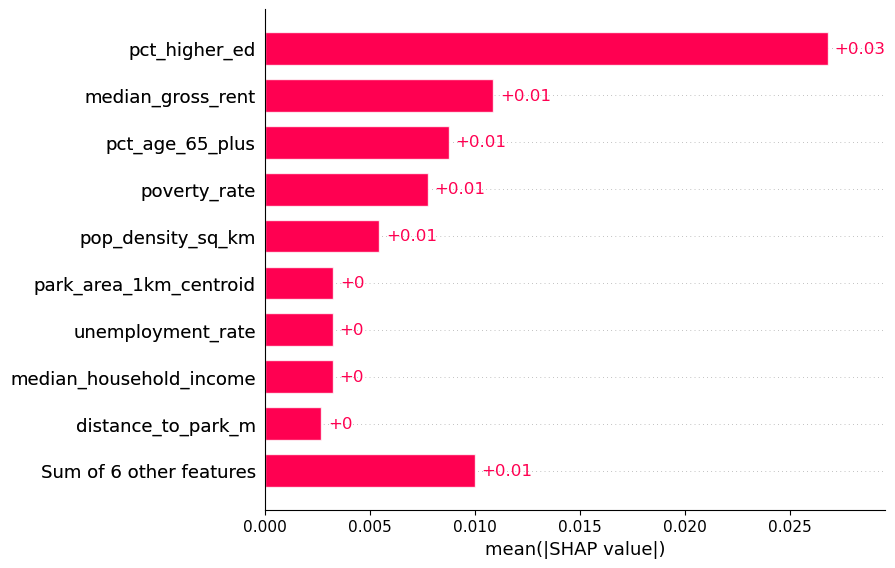

In [5]:
shap.plots.bar(shap_values)

The global importance plot shows that obesity prevalence predictions are most strongly influenced by educational attainment and other socioeconomic indicators, with built and natural environment features playing a less influential but non-negligible role. This suggests that the model primarily encodes socioeconomic interactions with obesity prevalence, while still incorporating park accessibilty and green space context to a degree.  

#### **B. Beeswarm Plot**

Driver Behaviors: How do high and low feature values impact model predictions across tracts?

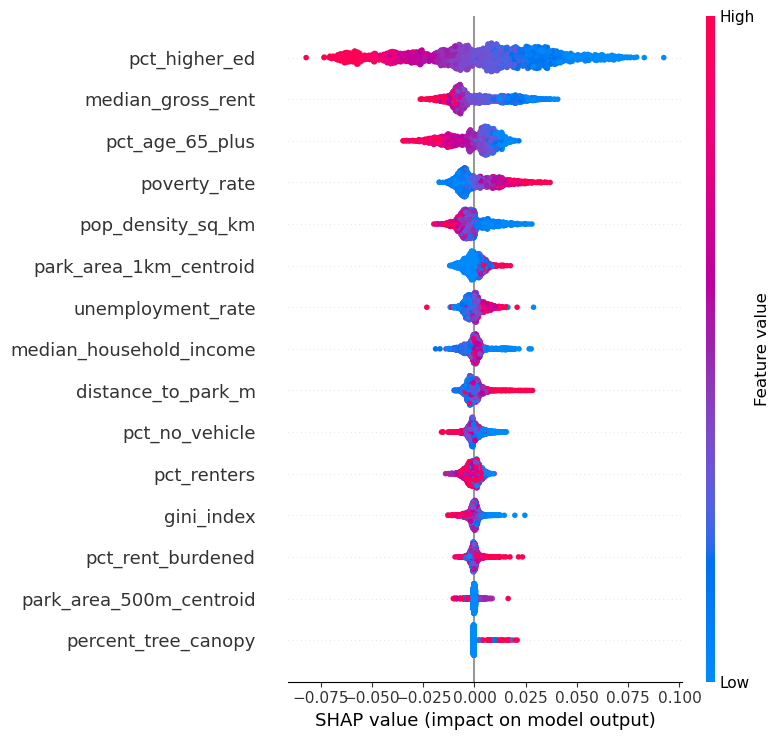

In [6]:
shap.summary_plot(shap_values, X)

This SHAP beeswarm plot gives us an idea of how specific values of the model's most influential features contribute to the model's predictions for tract-level obesity prevalence. Importantly, these observed relationships are correlations learned by the model rather than causal effects. As such, these results should be interpreted as signals for further investigation, such as causal inference, in order to make any policy reccomendations based on the features observed in the plot.

The most influential features in the model's predictions are pct_higher_ed, median_gross_rent, and pct_age_65_plus. Among these highly influential features, higher feature values are somewhat aligned with lower model predictions (and vice versa), but these relationships are not all perfectly linear or uniform across tracts. Given the presence of clustering, theres a possibility that some of these features behave differently depending on neighborhood context and interactions with other features. We will investigate this further in the dependence plots below. 

#### **C. Dependence Plots**

How do model predictions change with respect to individual features?

In this section, we take a closer look at 
1. High-influence features from beeswarm and global importance plots
2. Features that display clustering and non-linear shapes such as thresholds and plateaus (offer potential insights into feature interactions and context-dependent predictions)
3. Features that are particularly relevant to the policy question's being asked (e.g. How does the built environment impact health and long-run economic mobility? Which neighborhood characteristics are associated with favorable and unfavorable health and mobility outcomes?)

The code below creates dependence plots for each of the top features, along with plots for feature interaction. This is done in order to get a quick glance at all important features, allowing us to determine which are worth analyzing further. We are looking for features with some mix of the following: vertical spread, clear directionality, non-linearity/clustering/thresholds, coverage across the feature range, strong color seperation in feature interactions, or consistently positive or negative SHAP values. 

In [7]:
num_features_to_inspect = 15

# determine features with highest abs SHAP values
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

# sort features by SHAP value descending
top_features = [
    shap_values.feature_names[i]
    for i in np.argsort(mean_abs_shap)[::-1]
]

# select features for spot check
top_features = top_features[:num_features_to_inspect]

This code adds alot of clutter to the notebook. After reviewing all top features, we simply select the top 3-5 for in-depth analysis and remove this code's output from the notebook.

In [9]:
# for each feature: a dependence plot, and a feature interaction plot
'''
for feature in top_features:
    shap.plots.scatter(shap_values[:, feature])
    shap.dependence_plot(feature, shap_values.values, X)
'''

"\nfor feature in top_features:\n    print(f'\n Feature: {feature}')\n    shap.plots.scatter(shap_values[:, feature])\n    shap.dependence_plot(feature, shap_values.values, X)\n"

----------------------------

*pct_higher_ed*

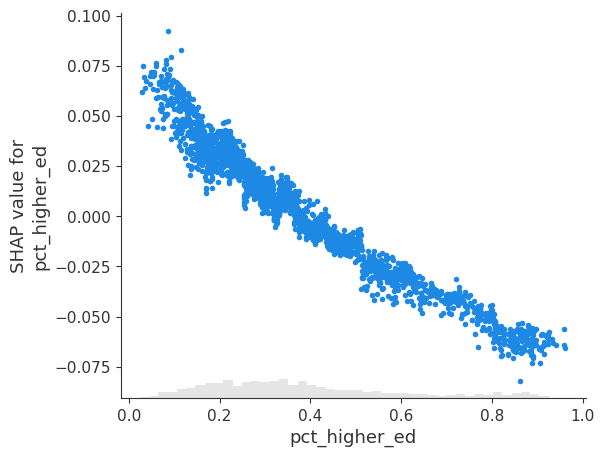

In [18]:
shap.plots.scatter(shap_values[:, "pct_higher_ed"])

Here we see a strong negative linear relationship between a tract's percentage of higher education degree holders and the model's obesity prevalence predictions. This indicates that higher educational attainment is consistently associated with lower predicted obesity prevalence across tracts.

---

*med_gross_rent*

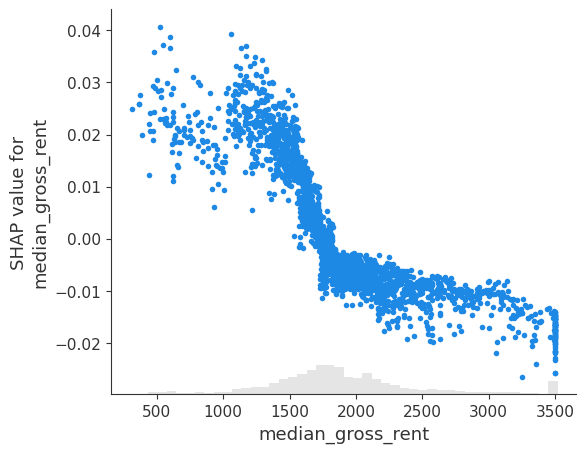

In [19]:
shap.plots.scatter(shap_values[:, "median_gross_rent"])

Here we see an interesting effect: at low median rent values, we see a modest association with higher predicted obesity prevalence. This continues up until around \\$1300, after which SHAP values drop and eventually negate, now leading to lower obesity prevalence predictions. This stabilizes around \\$1700. This threshold-like effect suggests that the model has learned an interaction with other features.

Below, we see that it might not be rent prices alone that are effecting predictions, but specifically the interaction between rent and percent higher education. Specifically, we see that after a certain rent threshold, there is an increase in percent higher education. **These high-rent, high-education tracts are associated with lower obesity prevalence predictions, pointing to the interactive relationship between educational attainment and income, and their combined effect on obesity prevalence. This could also suggest that rent behaves as a proxy for broader neighborhood socioeconomic context, especially educational attainment, rather than being an independent predictor of obesity prevalence.**

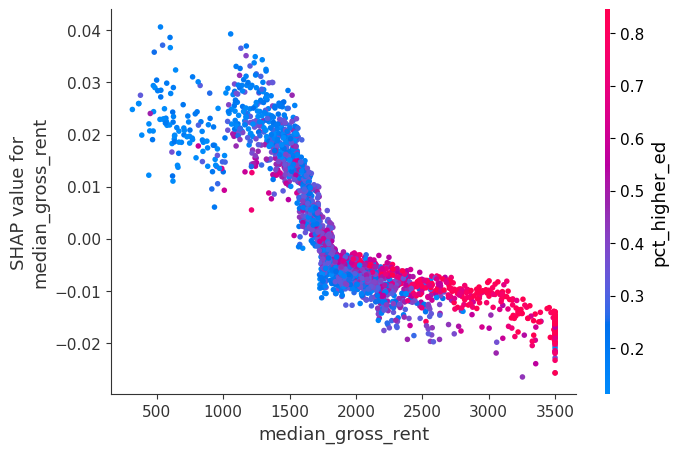

In [16]:
shap.dependence_plot('median_gross_rent', shap_values.values, X)

---

*pct_age_65_plus*

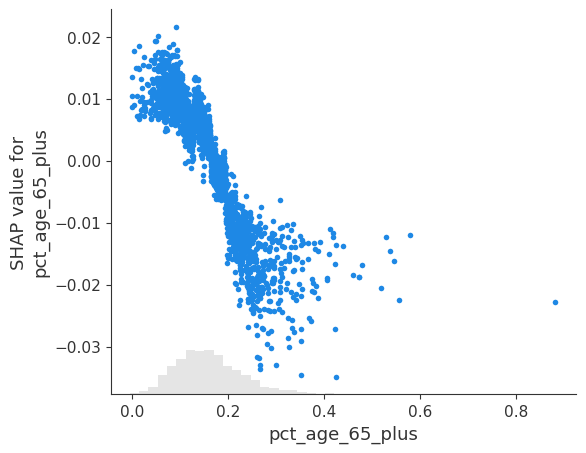

In [20]:
shap.plots.scatter(shap_values[:, "pct_age_65_plus"])

Here we see a moderate negative linear association between pct_age_65_plus and predicted obesity prevalence: tracts with lower rates of age 65+ are associated with increased obesity prevalence predictions, and vice versa. 

---

*poverty_rate*

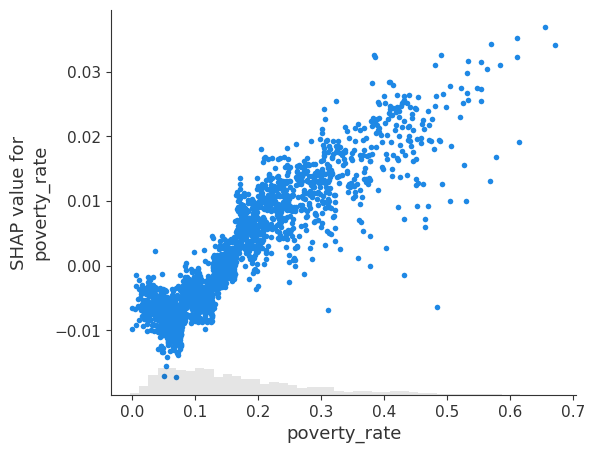

In [21]:
shap.plots.scatter(shap_values[:, "poverty_rate"])

Here we observe a moderate positive linear association between poverty rate and predicted obesity prevalence.

---

*park_area_1km_centroid*

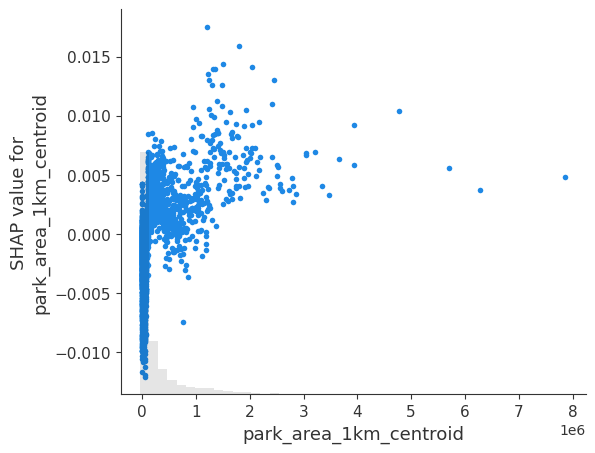

In [23]:
shap.plots.scatter(shap_values[:, "park_area_1km_centroid"])

Here we observe clustering at low park area values, combined with a wide range of SHAP values. This indicates that park area alone does not consistently contribute to predicted obesity prevalence. Instead, the influence of park area appears context-dependent and likely subject to other demographic and socioeconomic conditions. 

### 3. SHAP Summary

Overall, this SHAP analysis suggests that predicted obesity prevalence is primarily driven by socioeconomic factors, most notable being educational attainment. Features from the built and natural environment seem to provide a more context-dependent and conditional influence. This suggests that while environmental amenities may matter, it is their interaction with other neighborhood charactersists that influence obesity predictions. Overall, this suggests the need for cohesive and integrated policy approaches rather than single feature interventions.